# Example: Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.utils import parameters_to_vector
from torch.optim import Adam

from preds.models import MLPS
from preds.likelihoods import GaussianLh
from preds.datasets import SnelsonGen
from preds.laplace import Laplace

#### Hyperparameters

In [2]:
width = 25
depth = 3
prior_prec = 0.1
lr = 5e-3
n_epochs = 1000
lh = GaussianLh(sigma_noise=0.3)  # fixed to true noise

#### Dataset

In [3]:
device = 'cpu'
ds = SnelsonGen(train=True, n_samples=100, double=False)
X_train, y_train = ds.data.to(device), ds.targets.to(device).unsqueeze(1)
train_loader = [(X_train, y_train)]  # mock

#### Prediction grid for plot

In [4]:
offset = 1.5
x_min, x_max = ds.x_bounds
x_min, x_max = x_min-1.5, x_max+1.5
y_min, y_max = -3, 1.8
X = torch.linspace(x_min, x_max, 150).reshape(-1, 1).to(device)
x = X.cpu().flatten().numpy()


def plot_fit(pred_mu, pred_var, stds=2, ax=plt):
    ax.plot(x, pred_mu, c='tab:blue', lw=2)
    ax.fill_between(x, pred_mu-np.sqrt(pred_var)*stds, pred_mu+np.sqrt(pred_var)*stds, 
                    alpha=0.7, color='tab:blue')
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), 
               color='tab:red', s=50, lw=0.7, edgecolors='black', marker='o')

## Neural network training (MAP estimation)

In [5]:
model = MLPS(1, [width]*depth, 1, activation='tanh', flatten=False).to(device)
optim = Adam(model.parameters(), lr=lr)
losses = list()
for i in range(n_epochs):
    f = model(X_train)
    w = parameters_to_vector(model.parameters())
    reg = 0.5 * prior_prec * w @ w
    loss = - lh.log_likelihood(y_train, f) + reg
    loss.backward()
    optim.step()
    losses.append(loss.item())
    model.zero_grad()
# optionally: plt.plot(losses) to monitor convergence

## Infer Laplace-_GGN_ and predict

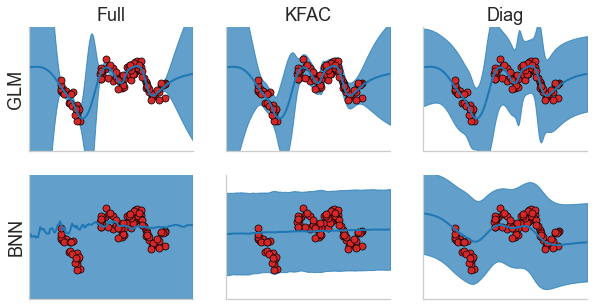

In [6]:
lap = Laplace(model, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(X, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(X, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    mu = mu.detach().cpu().squeeze().numpy()
    var = var.detach().cpu().squeeze().numpy()
    return mu, var


fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))

axs[0, 0].set_title('Full', fontsize=18)
axs[0, 1].set_title('KFAC', fontsize=18)
axs[0, 2].set_title('Diag', fontsize=18)
axs[0, 0].set_ylabel('GLM', fontsize=18)
axs[1, 0].set_ylabel('BNN', fontsize=18)

# GLM
mu, var = get_pred_for('glm', 'full')
plot_fit(mu, var, ax=axs[0, 0])
mu, var = get_pred_for('glm', 'kron')
plot_fit(mu, var, ax=axs[0, 1])
mu, var = get_pred_for('glm', 'diag')
plot_fit(mu, var, ax=axs[0, 2])

# NN
mu, var = get_pred_for('bnn', 'full')
plot_fit(mu, var, ax=axs[1, 0])
mu, var = get_pred_for('bnn', 'kron')
plot_fit(mu, var, ax=axs[1, 1])
mu, var = get_pred_for('bnn', 'diag')
plot_fit(mu, var, ax=axs[1, 2])

axs[0, 0].set_ylim([-4, 3])
axs[0, 0].set_xlim([x.min(), x.max()])
for axss in axs:
    for ax in axss:
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()